In [442]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [443]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [444]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,  func, inspect

In [445]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# review tables in database
inspector = inspect(engine)

inspector.get_table_names()


['measurement', 'station']

In [446]:
# reflect an existing database into a new model
Base = automap_base()

In [447]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [448]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [449]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [450]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [451]:
# Find names of columns within measurement for future reference
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [452]:
# Find the most recent date in the data set.  

# last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
# print(last_date)

last_date = session.query(func.max(measurement.date)).scalar()
print(last_date)



2017-08-23


In [453]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
 
last_date_obj = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
start_date = last_date_obj - dt.timedelta(days=365)
print(start_date)



2016-08-23


In [454]:

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, 
       func.sum(measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(measurement.date) >= start_date).\
        group_by(measurement.date).\
        order_by(measurement.date.desc()).all()

#precipitation


In [455]:

# Save the query results as a Pandas DataFrame. Explicitly set the column names
climate_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])
climate_df.head()
# Sort the dataframe by date
climate_df = climate_df.sort_values("Date").set_index("Date")
climate_df.head()


,Precipitation
Date,
2016-08-23,68.9
2016-08-24,236.9
2016-08-25,13.6
2016-08-26,2.6
2016-08-27,8.1


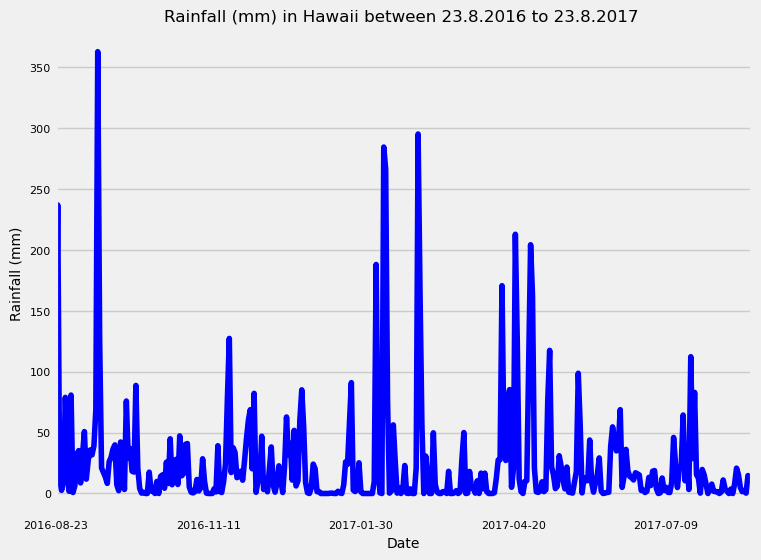

In [490]:
# Use Pandas Plotting with Matplotlib to plot the data


# Set the style and size of the plot elements
plt.rcParams.update({
    'font.size': 8,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))


# Plot the data
ax.plot(climate_df.index, climate_df['Precipitation'], color='blue')
ax.xaxis.grid(False)

# Set the x-axis limits and tick marks
ax.set_xlim(climate_df.index.min(0), climate_df.index.max())
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

# Set the labels
plt.title("Rainfall (mm) in Hawaii between 23.8.2016 to 23.8.2017 ")
ax.set_ylabel('Rainfall (mm)')
ax.set_xlabel('Date')
# Show the plot
plt.show()

In [456]:
# Use Pandas to calculate the summary statistics for the precipitation data
climate_df.describe()

,Precipitation
count,366.000000
mean,24.880874
std,45.110917
min,0.000000
25%,1.425000
50%,10.250000
75%,27.650000
max,362.700000


# Exploratory Station Analysis

In [457]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(measurement.station))).all()
total_stations

[(9,)]

In [458]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations




[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [459]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel = [func.max(measurement.tobs),
      func.min(measurement.tobs),
      func.avg(measurement.tobs)]
station_temp = session.query(*sel).filter(measurement.station == "USC00519281").\
    group_by(measurement.station)
for station in station_temp:
    print(station)



(29.4, 12.2, 22.03582251082252)


In [460]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(measurement.tobs).filter(measurement.station == 'USC00519281').\
        filter(measurement.date >= start_date).all()

station_df = pd.DataFrame(data, columns=['Temperature Observations'])

station_df.head()

,Temperature Observations
0,25.0
1,25.0
2,26.7
3,26.7
4,23.9


Text(0, 0.5, 'Counts')

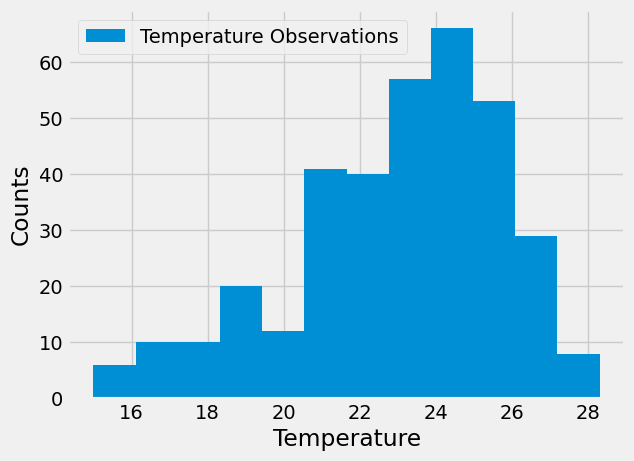

In [461]:
station_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Counts')


# Close Session

In [462]:
# Close Session
session.close()